In [1]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.io import SphericalTensor
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from e3nn_relaxed_model_tensor import RelaxedE3NN, RelaxedConvolution
from torch_geometric.data import Data
from utils import train, plot_output, plot_weights, setup_geom, print_relaxed_weights
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import random
import numpy as np
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# set random seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### First, we demonstrate the relaxed e3nn is equivariant at initialization.

In [3]:
num_nodes = 100
irreps_input = o3.Irreps("10x0e + 10x1e")
irreps_output = o3.Irreps("20x0e + 10x1e")
f_in = irreps_input.randn(num_nodes, -1)

pos = torch.randn(num_nodes, 3)  # random node positions
irreps_edge = o3.Irreps.spherical_harmonics(lmax=2)
#irreps_inter = o3.Irreps("0e")
# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)
data = Data(x = f_in, pos = pos)

In [4]:
model = RelaxedE3NN(irreps_input, irreps_output, irreps_edge, fc_neurons=256, num_neighbors=4, relaxed=True,num_layers=2,mul_relaxed_weights=2).to(device)

/Users/elyssahofgard/opt/miniconda3/envs/symm_breaking/lib/python3.9/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [5]:
rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot).to(device)

# rotate before
# edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)
data_before = Data(x = f_in @ D_in.T, pos = pos @ rot.T)
model.eval()
f_before = model(data_before.to(device))

# rotate after
f_after = model(data.to(device))@ D_out.T
print(torch.allclose(f_before, f_after, rtol=1e-6, atol=1e-6))

True


### 3D Deformation Examples

In [6]:
cube = torch.tensor([
        [-0.5, -0.5, -0.5],  # 0
        [0.5, -0.5, -0.5],   # 1
        [0.5, 0.5, -0.5],    # 2
        [-0.5, 0.5, -0.5],   # 3
        [-0.5, -0.5, 0.5],   # 4
        [0.5, -0.5, 0.5],    # 5
        [0.5, 0.5, 0.5],     # 6
        [-0.5, 0.5, 0.5]]) 

prism = cube.clone()
prism[:, 0] *= 0.5
prism[:, 1] *= 0.5
prism[:, 2] *= 2

# Define the coordinates for the less symmetric shape
length_x = 1.2
length_y = 1.5
length_z = 1.8

# Calculate half lengths
half_length_x = length_x / 2
half_length_y = length_y / 2
half_length_z = length_z / 2

# Define the coordinates for the less symmetric shape
# Define the coordinates for the less symmetric shape
random_shape = torch.tensor([
    [-half_length_x, -half_length_y, -half_length_z],  # 0
    [half_length_x, -half_length_y, -half_length_z],   # 1
    [half_length_x * 0.8, half_length_y * 1.2, -half_length_z * 0.6],  # 2
    [-half_length_x * 1.2, half_length_y * 0.8, -half_length_z * 1.4],  # 3
    [-half_length_x * 0.7, -half_length_y * 1.3, half_length_z],  # 4
    [half_length_x * 1.3, -half_length_y * 0.7, half_length_z * 0.5],  # 5
    [half_length_x, half_length_y, half_length_z],  # 6
    [-half_length_x, half_length_y, half_length_z]  # 7
])

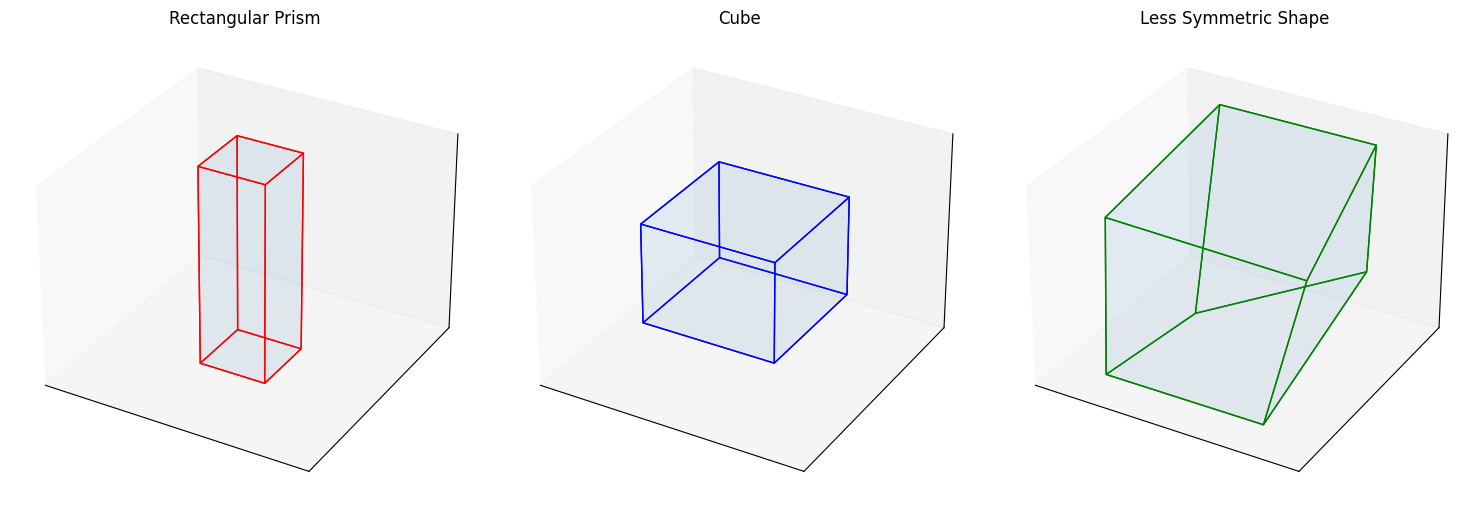

In [7]:
# Function to create faces from points
def create_faces(points):
    faces = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4], [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]]
    return faces

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

# Plotting
shapes = [prism, cube, random_shape]
colors = ['r', 'b', 'g']
titles = ['Rectangular Prism', 'Cube', 'Less Symmetric Shape']

for ax, shape, color, title in zip(axes, shapes, colors, titles):
    faces = Poly3DCollection([shape.numpy()[face] for face in create_faces(shape)], edgecolor=color, linewidths=1, alpha=0.05)
    ax.add_collection3d(faces)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.grid(False)

plt.tight_layout()
plt.show()

### First, we transform a cube to a cube and plot the resulting spherical harmonic signal.

In [8]:
# cube to cube
L_max = 2
L_max_relaxed = 4
irreps_input = o3.Irreps.spherical_harmonics(L_max)
irreps_output = o3.Irreps.spherical_harmonics(L_max) 
irreps_edge = o3.Irreps.spherical_harmonics(L_max)
data, projections = setup_geom(cube, cube,L_max)

In [9]:
model = RelaxedE3NN(irreps_input, irreps_output, irreps_edge, fc_neurons=256, num_neighbors=4, relaxed=True,num_layers=2,irreps_relaxed=L_max_relaxed,mul_relaxed_weights=1).to(device)
optimizer = torch.optim.SGD(model.parameters(),1e-2)

In [10]:
n_epochs = 800
losses_no_reg, best_output, best_model = train(data, projections, model, optimizer, n_epochs, regularize=True,use_scheduler=True)

epoch     0 | loss 9.296354  
epoch   200 | loss 0.000000  
epoch   400 | loss 0.000000  
epoch   600 | loss 0.000000  


In [11]:
relaxed_weights0 = best_model['model.RelaxedConvolution_0.relaxed_weights'].detach()
relaxed_weights1 = best_model['model.RelaxedConvolution_1.relaxed_weights'].detach()

In [12]:
even_ir_0 = print_relaxed_weights(relaxed_weights0,lmax_relaxed=L_max_relaxed,mul_relaxed=1)
even_ir_0 = np.hstack(even_ir_0)
even_ir_0[0] = 0

Irrep  0e
[1.11789]
Irrep  0o
[0.]
Irrep  1o
[ 0. -0. -0.]
Irrep  1e
[ 0. -0. -0.]
Irrep  2e
[ 0. -0. -0. -0.  0.]
Irrep  2o
[-0.  0. -0. -0.  0.]
Irrep  3o
[ 0.  0. -0.  0. -0.  0.  0.]
Irrep  3e
[ 0.  0. -0. -0.  0.  0. -0.]
Irrep  4e
[ 0.       -0.       -0.        0.        0.004955 -0.       -0.
 -0.        0.004187]
Irrep  4o
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
even_ir_1 = print_relaxed_weights(relaxed_weights1,lmax_relaxed=L_max_relaxed,mul_relaxed=1)
even_ir_1 = np.hstack(even_ir_1)
even_ir_1[0] = 0

Irrep  0e
[1.117738]
Irrep  0o
[0.]
Irrep  1o
[-0. -0.  0.]
Irrep  1e
[-0. -0. -0.]
Irrep  2e
[ 0.  0. -0. -0.  0.]
Irrep  2o
[ 0.  0. -0. -0.  0.]
Irrep  3o
[ 0.  0. -0.  0. -0. -0.  0.]
Irrep  3e
[ 0.  0.  0. -0.  0.  0. -0.]
Irrep  4e
[ 0.        0.       -0.       -0.        0.015661  0.        0.
  0.        0.013236]
Irrep  4o
[ 0. -0. -0. -0.  0.  0. -0. -0. -0.]


In [14]:
# convert to spherical harmonics
def convert_to_sh(s1,s2):
    x2 = (-1/2)*np.sqrt(5)*s1 - (1/2)*(np.sqrt(15))*s2
    y2 = np.sqrt(5)*s1
    z2 = (-1/2)*np.sqrt(5)*s1 + (1/2)*(np.sqrt(15))*s2
    print('x^2: ', x2)
    print('y^2: ', y2)
    print('z^2: ', z2)

In [15]:
s1 = even_ir_0[6] + even_ir_1[6]
s2 = even_ir_0[8] + even_ir_1[8]
convert_to_sh(s1,s2)

x^2:  0.0
y^2:  -0.0
z^2:  0.0


In [16]:
# plot spherical harmonic projection
sph = SphericalTensor(L_max_relaxed, p_val=1, p_arg=-1)
    #r,f = sph.plot(signal = torch.tensor(relaxed_weights))
fig = go.Figure([go.Surface(**sph.plotly_surface(torch.tensor(even_ir_1),radius=True)[0])])
# Update layout to remove background and axes
fig.update_layout(
    scene=dict(
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
        aspectmode="data"
    ),
    showlegend=False
)
fig.show()

### Do the same for a cube to a rectangular prism.

In [22]:
data, projections = setup_geom(cube, prism,L_max)

In [23]:
model = RelaxedE3NN(irreps_input, irreps_output, irreps_edge, fc_neurons=256, num_neighbors=4, relaxed=True,num_layers=2,irreps_relaxed=L_max_relaxed,mul_relaxed_weights=1).to(device)
optimizer = torch.optim.SGD(model.parameters(),1e-2)

In [24]:
n_epochs = 2500
losses_no_reg, best_output, best_model = train(data, projections, model, optimizer, n_epochs, regularize=True,use_scheduler=True)

epoch     0 | loss 19.427842 
epoch   200 | loss 0.001072  
epoch   400 | loss 0.000006  
epoch   600 | loss 0.000000  
epoch   800 | loss 0.000000  
epoch  1000 | loss 0.000000  
epoch  1200 | loss 0.000000  
epoch  1400 | loss 0.000000  
epoch  1600 | loss 0.000000  
epoch  1800 | loss 0.000000  
epoch  2000 | loss 0.000000  
epoch  2200 | loss 0.000000  
epoch  2400 | loss 0.000000  


In [25]:
relaxed_weights0 = best_model['model.RelaxedConvolution_0.relaxed_weights'].detach()
relaxed_weights1 = best_model['model.RelaxedConvolution_1.relaxed_weights'].detach()

In [26]:
even_ir_0 = print_relaxed_weights(relaxed_weights0,lmax_relaxed=L_max_relaxed,mul_relaxed=1)
even_ir_0 = np.hstack(even_ir_0)
even_ir_0[0] = 0

Irrep  0e
[1.033985]
Irrep  0o
[0.]
Irrep  1o
[ 0.  0. -0.]
Irrep  1e
[-0. -0. -0.]
Irrep  2e
[ 0.       -0.        0.454661 -0.       -0.787496]
Irrep  2o
[-0.  0. -0.  0.  0.]
Irrep  3o
[ 0.  0. -0.  0. -0. -0. -0.]
Irrep  3e
[ 0.  0.  0.  0.  0. -0. -0.]
Irrep  4e
[-0.       -0.        0.       -0.       -0.039916  0.       -0.070393
 -0.        0.019477]
Irrep  4o
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
even_ir_1 = print_relaxed_weights(relaxed_weights1,lmax_relaxed=L_max_relaxed,mul_relaxed=1)
even_ir_1 = np.hstack(even_ir_1)
even_ir_1[0] = 0

Irrep  0e
[0.367138]
Irrep  0o
[0.]
Irrep  1o
[-0. -0.  0.]
Irrep  1e
[ 0. -0.  0.]
Irrep  2e
[-0.        0.        0.649465  0.       -1.124907]
Irrep  2o
[-0. -0.  0.  0.  0.]
Irrep  3o
[ 0.  0. -0.  0. -0.  0. -0.]
Irrep  3e
[ 0. -0.  0. -0.  0. -0.  0.]
Irrep  4e
[ 0.       -0.       -0.        0.        0.199303 -0.       -0.11338
 -0.        0.254149]
Irrep  4o
[-0. -0.  0.  0. -0. -0.  0.  0.  0.]


In [28]:
s1 = even_ir_0[6] + even_ir_1[6]
s2 = even_ir_0[8] + even_ir_1[8]
convert_to_sh(s1,s2)

x^2:  2.468902089256085
y^2:  2.468900791724933
z^2:  -4.937802880981018


In [29]:
# plot spherical harmonic projection
sph = SphericalTensor(L_max_relaxed, p_val=1, p_arg=-1)
    #r,f = sph.plot(signal = torch.tensor(relaxed_weights))
fig = go.Figure([go.Surface(**sph.plotly_surface(torch.tensor(even_ir_1),radius=True)[0])])
# Update layout to remove background and axes
fig.update_layout(
    scene=dict(
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
        aspectmode="data"
    ),
    showlegend=False
)
fig.show()

### Finally, do the same for a cube to asymmetric shape.

In [33]:
data, projections = setup_geom(cube, random_shape,L_max)

In [34]:
model = RelaxedE3NN(irreps_input, irreps_output, irreps_edge, fc_neurons=256, num_neighbors=4, relaxed=True,num_layers=3,irreps_relaxed=L_max_relaxed,mul_relaxed_weights=1).to(device)
optimizer = torch.optim.SGD(model.parameters(),1e-2)

In [35]:
n_epochs = 2500
losses_no_reg, best_output, best_model = train(data, projections, model, optimizer, n_epochs, regularize=True,use_scheduler=True)

epoch     0 | loss 8.960592  
epoch   200 | loss 1.630688  
epoch   400 | loss 0.438296  
epoch   600 | loss 0.396618  
epoch   800 | loss 0.371759  
epoch  1000 | loss 0.354954  
epoch  1200 | loss 0.342923  
epoch  1400 | loss 0.334027  
epoch  1600 | loss 0.327337  
epoch  1800 | loss 0.322276  
epoch  2000 | loss 0.318446  
epoch  2200 | loss 0.315557  
epoch  2400 | loss 0.313386  


In [36]:
relaxed_weights0 = best_model['model.RelaxedConvolution_0.relaxed_weights'].detach()
relaxed_weights1 = best_model['model.RelaxedConvolution_1.relaxed_weights'].detach()

In [37]:
even_ir_0 = print_relaxed_weights(relaxed_weights0,lmax_relaxed=L_max_relaxed,mul_relaxed=1)
even_ir_0 = np.hstack(even_ir_0)
even_ir_0[0] = 0

Irrep  0e
[1.104824]
Irrep  0o
[0.]
Irrep  1o
[-0.102335  0.009903 -0.171298]
Irrep  1e
[-0.067577 -0.002192 -0.028704]
Irrep  2e
[-0.036025 -0.008772 -0.029685  0.002666 -0.032339]
Irrep  2o
[ 0.006109 -0.002557 -0.001793 -0.005974  0.012415]
Irrep  3o
[ 0.002552 -0.002764  0.002592 -0.000948  0.002782 -0.001068  0.004025]
Irrep  3e
[-0.003892  0.       -0.002322 -0.001333 -0.000193  0.000908 -0.000883]
Irrep  4e
[-9.600e-05  5.520e-04 -7.260e-04  1.583e-03  3.574e-03 -1.317e-03
 -1.413e-03  2.960e-04  3.982e-03]
Irrep  4o
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [38]:
even_ir_1 = print_relaxed_weights(relaxed_weights1,lmax_relaxed=L_max_relaxed,mul_relaxed=1)
even_ir_1 = np.hstack(even_ir_1)
even_ir_1[0] = 0

Irrep  0e
[0.989647]
Irrep  0o
[0.016775]
Irrep  1o
[-0.019848 -0.002456  0.065412]
Irrep  1e
[-0.062134 -0.131284 -0.111269]
Irrep  2e
[ 0.129513 -0.085128 -0.330307  0.028695 -0.214606]
Irrep  2o
[-0.066497  0.077551  0.208775 -0.196151  0.092036]
Irrep  3o
[ 0.065207 -0.021179 -0.046356 -0.038629 -0.03028  -0.021593  0.04004 ]
Irrep  3e
[ 0.001829 -0.004154 -0.006476  0.000343  0.008307 -0.001821  0.001426]
Irrep  4e
[ 0.004352 -0.01804   0.011114  0.009304  0.026145  0.022978  0.034514
  0.03178  -0.0078  ]
Irrep  4o
[ 0.00748  -0.006053 -0.006536  0.017915 -0.009032 -0.004707  0.00021
  0.00755   0.010426]


In [39]:
s1 = even_ir_0[6] + even_ir_1[6]
s2 = even_ir_0[8] + even_ir_1[8]
convert_to_sh(s1,s2)

x^2:  0.8806902278926475
y^2:  -0.8049665833561044
z^2:  -0.07572364453654312


In [40]:
# plot spherical harmonic projection
sph = SphericalTensor(L_max_relaxed, p_val=1, p_arg=-1)
    #r,f = sph.plot(signal = torch.tensor(relaxed_weights))
fig = go.Figure([go.Surface(**sph.plotly_surface(torch.tensor(even_ir_1),radius=True)[0])])
# Update layout to remove background and axes
fig.update_layout(
    scene=dict(
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
        aspectmode="data"
    ),
    showlegend=False
)
fig.show()

In [44]:
# heatmap of nonzero for the last layer
cube = [0, 0, 0, 0, 0, 0, 2/9, 0]
prism = [0, 0, 2/5, 0, 0, 0, 3/9, 0]
random_shape = [1,1,1,1,1,1,1,1]
matrix = np.hstack([cube,prism,random_shape]).reshape(3,len(cube))

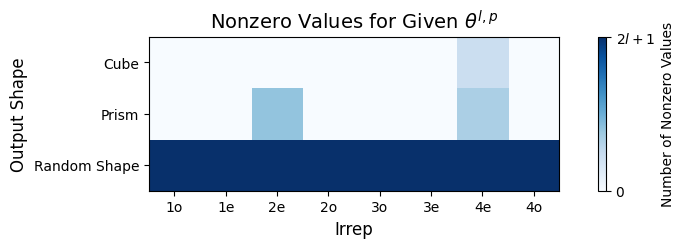

In [45]:
# Plot the heatmap with the custom colormap
plt.figure(figsize=(10, 2))  # Adjust the figsize as needed
plt.imshow(matrix, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
cbar = plt.colorbar(label="Number of Nonzero Values",orientation='vertical')
# Customize colorbar ticks and labels
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0', r'$2l+1$'])
cbar.ax.tick_params(labelsize=10)  # Increase colorbar font size

plt.title(r'Nonzero Values for Given $\theta^{l,p}$', fontsize=14)
plt.xlabel('Irrep', fontsize=12)
plt.ylabel('Output Shape', fontsize=12)
plt.xticks(np.arange(len(cube)), labels=['1o', '1e', '2e', '2o', '3o', '3e', '4e', '4o'], fontsize=10)
plt.yticks(np.arange(3), labels=['Cube', 'Prism', 'Random Shape'], fontsize=10)
plt.savefig('sparsity_of_relaxed_weight_signal.pdf', format='pdf', bbox_inches='tight')
plt.show()
